### Step 1: Prerequisites and Dataset

In [ ]:
%pip install datasets torch tokenizer tiktoken matplotlib ipywidgets jupyter

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

### Step 2: Tokenizing the Dataset

In [3]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

encoder = tiktoken.get_encoding("gpt2")

def process(example, encoder=None):
    ids = encoder.encode_ordinary(example["text"])
    return {"ids": ids, "len": len(ids)}

# Only map once
tokenizer = ds.map(
    process,
    fn_kwargs={"encoder": encoder},     # <-- always pass encoder
    remove_columns=["text"],
    desc="tokenizing the splits",
    num_proc=os.cpu_count(),
)

if not os.path.exists("train.bin"):
    for split_name, dset in tokenizer.items():   # loop over train/valid/test splits
        arr_len = np.sum(dset["len"])
        filename = f"{split_name}.bin"

        dtype = np.uint16
        arr = np.memmap(filename, dtype=dtype, mode="w+", shape=(arr_len,))
        total_batches = 1024*2^10

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f"writing {filename}"):
            # Batch together samples for faster write
            batch = (
                dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True)
                .with_format("numpy")
            )
            arr_batch = np.concatenate(batch["ids"])

            # write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)

        arr.flush()

### Step 3: Create Input-Output batches for the dataset

In [ ]:
def get_batch(split):
    if split == 'train':
        data = np.memmap('train.bin', dtype = np.uint16, mode = 'r')
    else:
        data = np.memmap('validation.bin', dtype = np.uint16, mode = 'r')

    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x,y

: 

### Step 4: Define the SLM Model Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3*config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1,2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1,2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1,2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1))* (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std = 0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature = 1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """

        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples = 1)
            idx = torch.cat((idx, idx_next), dim = 1)
        return idx

: 

In [ ]:
config = GPTConfig(
    vocab_size = 50257,
    block_size = 128,
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

### Step 5: Define the loss function

In [7]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

### Step 6: Define SLM Training Configuration Part 1

In [8]:
# Training config
import torch
from contextlib import nullcontext

learning_rate = 1e-4
max_iters = 20000
warmup_steps = 1000
min_lr = 5e-4
eval_iters = 500
batch_size = 32
block_size = 128

gradient_accumulation_steps = 32

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_type = 'cuda' if 'cuda' in device else 'cpu'

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type = device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

### Step 7: Define SLM Training Configuration Part 2

In [9]:
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, betas=(0.9, 0.95), weight_decay = 0.1, eps=1e-9)

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps)
scheduler_delay = CosineAnnealingLR(optimizer, T_max = max_iters - warmup_steps, eta_min = min_lr)
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_delay], milestones=[warmup_steps])

scaler = torch.amp.GradScaler(enabled=(dtype == 'float16'))

### Step 8: Pre-Train the SLM

In [10]:
best_val_loss = float('Inf')
best_model_params_path = './best_model_params.pt'
train_loss_list, validation_loss_list = [], []

model = model.to(device)

for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current Learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    X,y = get_batch("train")
    X,y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/20000 [00:00<?, ?it/s]

C:\Users\Tanmay Sapra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 500: train loss 9.4536, val loss 9.4607
The current Learning rate: 0.00007


C:\Users\Tanmay Sapra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1000: train loss 8.5085, val loss 8.5131
The current Learning rate: 0.00010
Epoch 1500: train loss 7.5564, val loss 7.5570
The current Learning rate: 0.00010
Epoch 2000: train loss 6.7001, val loss 6.7026
The current Learning rate: 0.00010
Epoch 2500: train loss 6.0091, val loss 6.0036
The current Learning rate: 0.00011
Epoch 3000: train loss 5.4905, val loss 5.4900
The current Learning rate: 0.00011
Epoch 3500: train loss 5.0677, val loss 5.0672
The current Learning rate: 0.00012
Epoch 4000: train loss 4.7443, val loss 4.7424
The current Learning rate: 0.00012
Epoch 4500: train loss 4.5009, val loss 4.5001
The current Learning rate: 0.00013
Epoch 5000: train loss 4.2897, val loss 4.2945
The current Learning rate: 0.00014
Epoch 5500: train loss 4.1278, val loss 4.1260
The current Learning rate: 0.00015
Epoch 6000: train loss 3.9555, val loss 3.9599
The current Learning rate: 0.00016
Epoch 6500: train loss 3.8199, val loss 3.8344
The current Learning rate: 0.00018
Epoch 7000: trai

### Step 9: Plot the SLM Loss Function

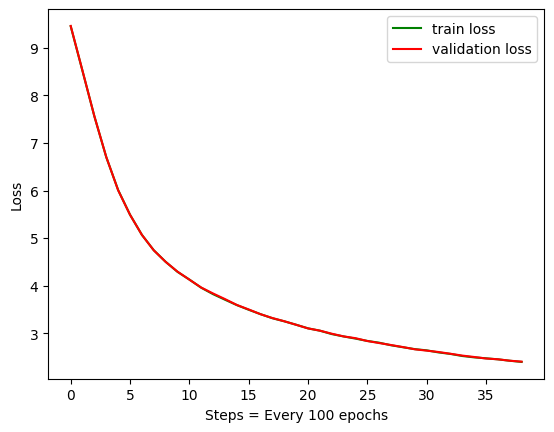

In [11]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validate_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label = 'train loss')
plt.plot(validate_loss_list_converted, 'r', label = 'validation loss')
plt.xlabel("Steps = Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Step 10: Run SLM Inference on our trained model

In [12]:
%pip install tiktoken
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("gpt2")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
model = GPT(config)
device = 'cuda'
best_model_params_path = 'best_model_params.pt'
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)))

C:\Users\Tanmay Sapra\AppData\Local\Temp\ipykernel_1620\1792525618.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_pat

<All keys matched successfully>

In [14]:
sentence = "Once upon a time there was a pumpkin."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Once upon a time there was a pumpkin. Everyone was very excited and wanted to go on the lawn. One day, Joe hopped into the garden and smiled with excitement. He had already found a mixer all so red leaves! Sammy tried to grab the steak, but it was too cold.

Mark didn't but frowned. They had an idea. They took the sandwich in a bite you and came in the oven. Inside the kitchen, there was wider than terrible things in the plate. Sally was so happy he had eaten up the mixer, but he was not happy. He drank melony and said goodbye to it!

When the damage was done, child wasn't happy to br tested her best rule. They started to cry in time â€œYeah, letâ€™s do a hot with the cart.â€“ a friendly man had ate the cake until the pizza was nice and happy.

Where about she had eaten their tea party of snow, thanked the driver with an honest


In [15]:
sentence = "A little girl went to the woods"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

A little girl went to the woods, but Mom said, "Em! Come inside with me in." It was time soon.

Emma was very happy. She ate all of the plants, encourage her dad to make sure Lily came down. This time, she tried to copy the frog to get the carrot. Lily was very happy and they all played the sheep happily all day long.Once upon a time, there was a small boy named Timmy. Timmy liked to play with his toys and make them look for snakes. When Timmy's mommy came over, said, "Timmy, that's important to clean up your toys get home so loving around. I can't have to buy"Mommy, can we, Mommy?"Timmy was in the living room. She wanted to wrap up.

"Timmy, Daddy, Lily, can you make me clean so that we can clean your toys!" he said, "I feel anxious!" 

His mom smiled and said
